In [11]:
import os
# make everything single-threaded so it plays nice in some environments
os.environ["OPENCV_DISABLE_OPENMP"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random

In [12]:
# to run this script and other files with absolute paths on your own device, you must change the file path.
!python '/content/drive/MyDrive/RecycleBuddy/scripts/preprocess.py'

2025-12-04 00:38:51.949506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764808731.971572   14245 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764808731.978212   14245 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764808731.994981   14245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764808731.995025   14245 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764808731.995028   14245 computation_placer.cc:177] computation placer alr

In [13]:
# --- configuration ---
IMG_SIZE = 224
# original classes: cardboard(0), glass(1), metal(2), paper(3), plastic(4), trash(5)
ORIGINAL_CLASSES = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
BINARY_CLASSES = ['RECYCLABLE', 'NON-RECYCLABLE']

# path to your preprocessed .npy files
# note: '../' assumes you're inside a 'notebooks/' folder under the project root
DATA_DIR = "../data/preprocessed/"

# load preprocessed 6-class data
try:
    X_train = np.load(os.path.join(DATA_DIR, "/content/drive/MyDrive/RecycleBuddy/data/preprocessed/X_train.npy"), mmap_mode='r')
    y_train_6class = np.load(os.path.join(DATA_DIR, "/content/drive/MyDrive/RecycleBuddy/data/preprocessed/y_train.npy"), mmap_mode='r')
    X_val = np.load(os.path.join(DATA_DIR, "/content/drive/MyDrive/RecycleBuddy/data/preprocessed/X_val.npy"), mmap_mode='r')
    y_val_6class = np.load(os.path.join(DATA_DIR, "/content/drive/MyDrive/RecycleBuddy/data/preprocessed/y_val.npy"), mmap_mode='r')
    X_test = np.load(os.path.join(DATA_DIR, "/content/drive/MyDrive/RecycleBuddy/data/preprocessed/X_test.npy"), mmap_mode='r')
    y_test_6class = np.load(os.path.join(DATA_DIR, "/content/drive/MyDrive/RecycleBuddy/data/preprocessed/y_test.npy"), mmap_mode='r')
except FileNotFoundError:
    print(f"🚨 error: preprocessed data files not found in {DATA_DIR}. make sure 'preprocess.py' was run successfully.")
    raise

# cast to float16 to save memory (helpful for big image sets)
X_train = X_train.astype('float16')
X_val   = X_val.astype('float16')
X_test  = X_test.astype('float16')

print("✅ 6-class data loaded.")

# --- binary label conversion ---
# classes 0–4 (cardboard, glass, metal, paper, plastic) → recyclable (0)
# class 5 (trash) → non-recyclable (1)
def convert_to_binary_labels(y_6class):
    # y_6class is one-hot encoded (e.g., [0, 0, 0, 0, 1, 0])
    # first grab the original class index (e.g., 4 for plastic)
    y_indices = np.argmax(y_6class, axis=1)

    # map 0–4 → 0 (recyclable), 5 → 1 (non-recyclable)
    y_binary_indices = np.where(y_indices < 5, 0, 1)

    # convert back to 2-class one-hot encoding
    return to_categorical(y_binary_indices, num_classes=2)

y_train = convert_to_binary_labels(y_train_6class)
y_val   = convert_to_binary_labels(y_val_6class)
y_test  = convert_to_binary_labels(y_test_6class)

print("✅ labels converted to binary classification (2 classes).")
print(f"train shapes: X {X_train.shape}, y {y_train.shape}")
print(f"val shapes:   X {X_val.shape}, y {y_val.shape}")
print(f"test shapes:  X {X_test.shape}, y {y_test.shape}")

✅ 6-class data loaded.
✅ labels converted to binary classification (2 classes).
train shapes: X (1768, 224, 224, 3), y (1768, 2)
val shapes:   X (379, 224, 224, 3), y (379, 2)
test shapes:  X (380, 224, 224, 3), y (380, 2)


In [14]:
# building a cnn for 2-class classification
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
NUM_CLASSES = 2

model = Sequential([
    Input(shape=INPUT_SHAPE),  # explicit input layer for clarity

    # first conv block
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # second conv block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # third conv block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # classification head
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # final layer: 2 outputs → recyclable / non-recyclable
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # using one-hot labels
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,784,130 (98.36 MB)

 Trainable params: 25,784,130 (98.36 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
print("starting training for 2-class classification...")

# early stopping to keep the best model and avoid overfitting
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=4,
    callbacks=[es],
    verbose=1
)

starting training for 2-class classification...
Epoch 1/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9523 - loss: 1.0360 - val_accuracy: 0.9446 - val_loss: 0.2491
Epoch 2/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9471 - loss: 0.2858 - val_accuracy: 0.9446 - val_loss: 0.3723
Epoch 3/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9501 - loss: 0.3575 - val_accuracy: 0.9446 - val_loss: 0.2224
Epoch 4/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9419 - loss: 0.3050 - val_accuracy: 0.9446 - val_loss: 0.2091
Epoch 5/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9523 - loss: 0.2099 - val_accuracy: 0.9446 - val_loss: 0.2087
Epoch 6/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9411 - loss: 0.2317 - val_accuracy: 0.9446 - val_loss: 0.2291
Epoch 7/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9375 - loss: 0.2981 - val_accuracy: 0.9446 - val_loss: 0.2273
Epoch 8/30
442/442 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - ac


--- overall accuracy ---
✅ test accuracy: 94.74%
test loss: 0.2054

--- classification report (precision, recall, f1-score) ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
RECYCLABLE,0.947368,1.000000,0.972973,360.000000
NON-RECYCLABLE,0.000000,0.000000,0.000000,20.000000
accuracy,0.947368,0.947368,0.947368,0.947368
macro avg,0.473684,0.500000,0.486486,380.000000
weighted avg,0.897507,0.947368,0.921764,380.000000



--- confusion matrix ---


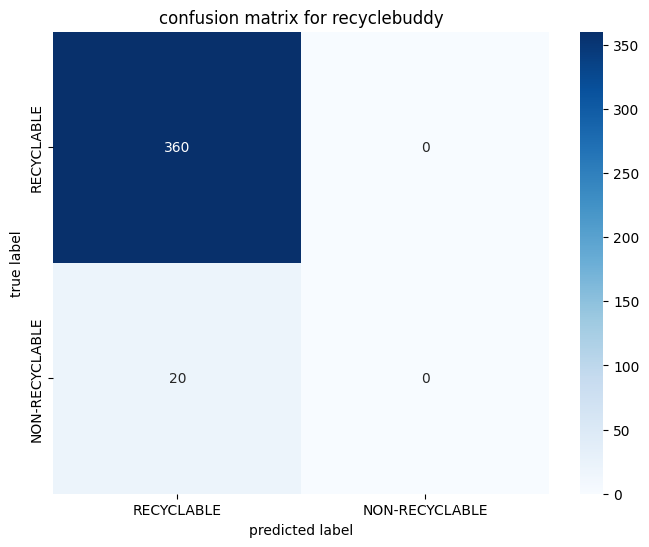

In [16]:
# --- 1. predictions ---
# predict class probabilities and convert to class indices
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# --- 2. overall accuracy ---
print("\n--- overall accuracy ---")
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f"✅ test accuracy: {test_acc * 100:.2f}%")
print(f"test loss: {test_loss:.4f}")

# --- 3. classification report (precision, recall, f1) ---
print("\n--- classification report (precision, recall, f1-score) ---")
report = classification_report(y_true, y_pred, target_names=BINARY_CLASSES, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

# --- 4. confusion matrix plot ---
print("\n--- confusion matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=BINARY_CLASSES,
    yticklabels=BINARY_CLASSES
)
plt.title("confusion matrix for recyclebuddy")
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [17]:
# save the final 2-class model
MODEL_NAME = "recyclebuddy_binary_model.h5"
# correct relative path from 'notebooks/' to 'models/'
MODEL_SAVE_DIR = "/content/drive/MyDrive/RecycleBuddy/models"

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model.save(os.path.join(MODEL_SAVE_DIR, MODEL_NAME))
print(f"💾 2-class model saved as {MODEL_NAME} in {MODEL_SAVE_DIR}")

# quick check so the exporter script doesn't have surprises
saved_path = os.path.join(MODEL_SAVE_DIR, MODEL_NAME)
if os.path.exists(saved_path):
    print(f"✅ verification: model found at {saved_path}. ready for tf.js export.")
else:
    print(f"❌ verification: model not found at {saved_path}. check the save path.")

💾 2-class model saved as recyclebuddy_binary_model.h5 in /content/drive/MyDrive/RecycleBuddy/models
✅ verification: model found at /content/drive/MyDrive/RecycleBuddy/models/recyclebuddy_binary_model.h5. ready for tf.js export.


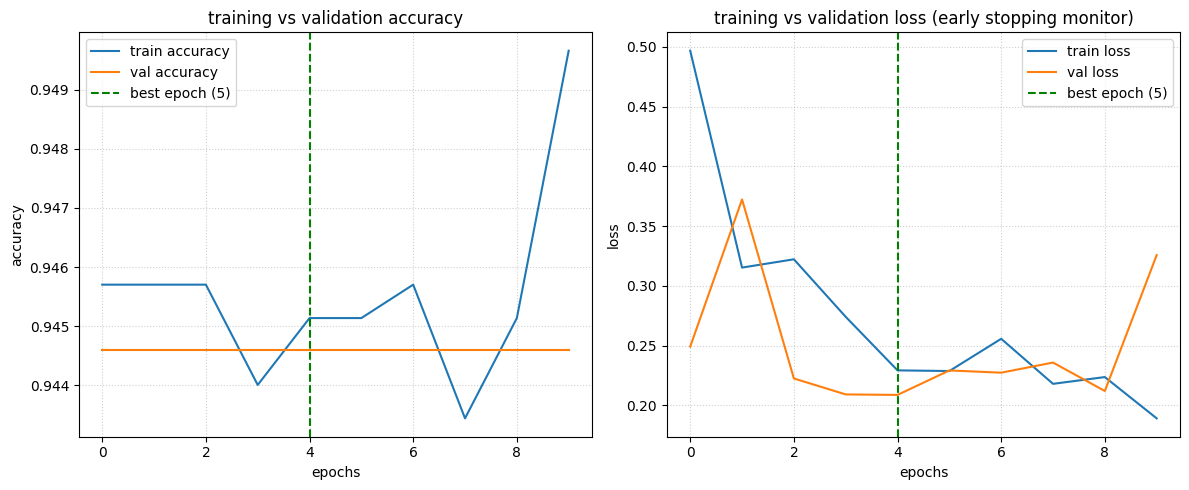

In [18]:
plt.figure(figsize=(12, 5))

# compute best epoch based on lowest validation loss
best_epoch = int(np.argmin(history.history['val_loss']))

# --- plot 1: accuracy ---
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'best epoch ({best_epoch + 1})')
plt.title("training vs validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

# --- plot 2: loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'best epoch ({best_epoch + 1})')
plt.title("training vs validation loss (early stopping monitor)")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

X_test dtype: float16


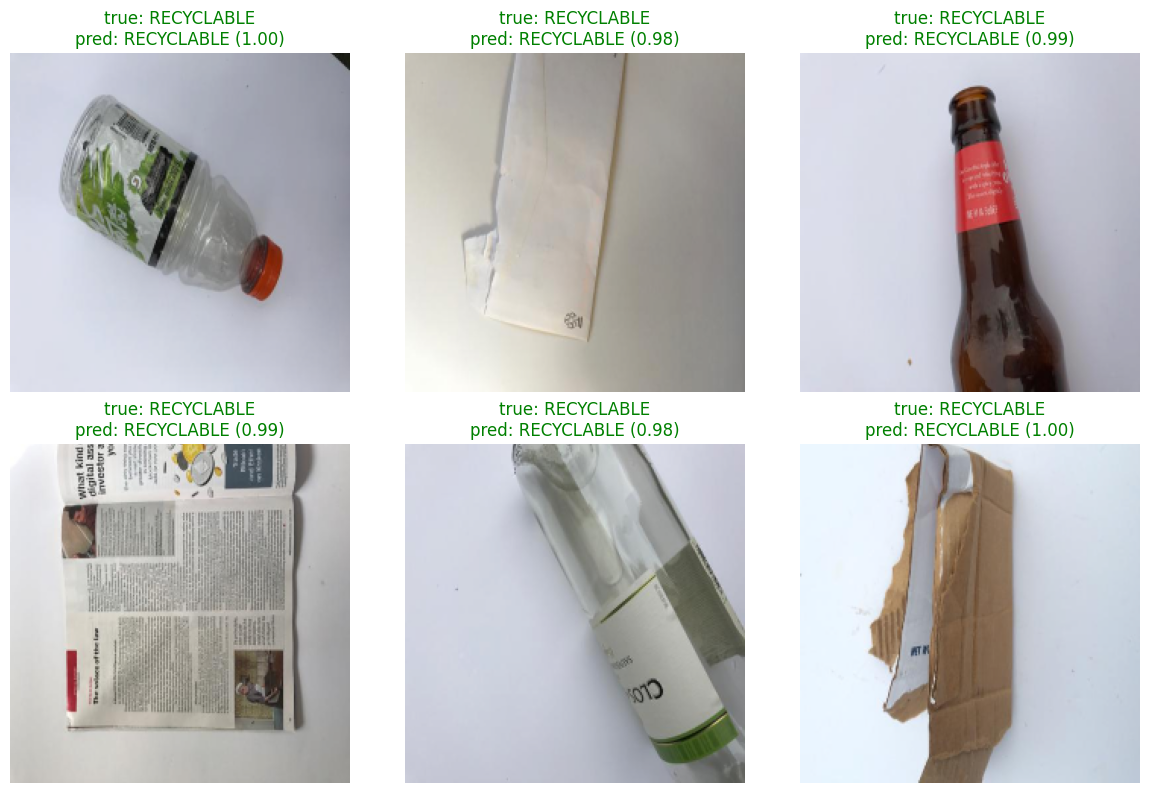

In [19]:
# plotting random test samples with predictions
# note: y_pred, y_pred_probs, y_test, X_test are created in earlier cells

print("X_test dtype:", X_test.dtype)

try:
    indices = random.sample(range(len(X_test)), 6)
except ValueError:
    print("not enough samples in X_test to draw 6 random samples.")
    indices = range(len(X_test))

plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices):
    plt.subplot(2, 3, i + 1)

    # grab image and force it into a safe dtype for matplotlib
    img = np.asarray(X_test[idx])  # ensure it's a numpy array

    # if it's float16 or any weird type, convert to float32
    if img.dtype not in (np.float32, np.float64, np.uint8):
        img = img.astype('float32')

    # if values are in [0, 1] already, cool; if they look like [0, 255], also fine
    # if they are larger than 255 for some reason, rescale them to [0, 1]
    if img.max() > 255:
        img = img / img.max()

    plt.imshow(img)
    plt.axis('off')

    true_label = BINARY_CLASSES[np.argmax(y_test[idx])]
    pred_label = BINARY_CLASSES[y_pred[idx]]

    # predicted class confidence
    confidence = float(y_pred_probs[idx][y_pred[idx]])

    # green if correct, red if wrong
    color = "green" if true_label == pred_label else "red"

    plt.title(
        f"true: {true_label}\npred: {pred_label} ({confidence:.2f})",
        color=color
    )

plt.tight_layout()
plt.show()

X_test dtype: float16


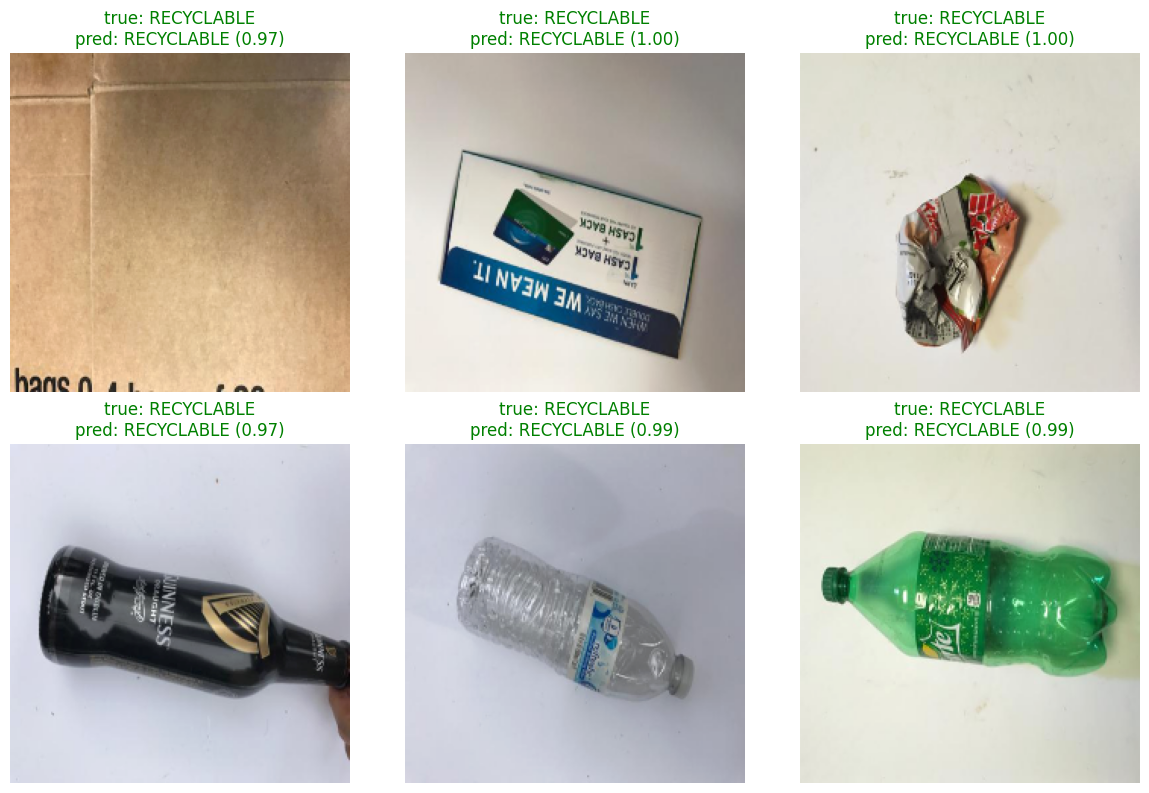

In [20]:
# plotting random test samples with predictions
# note: y_pred, y_pred_probs, y_test, X_test must be defined already

print("X_test dtype:", X_test.dtype)

try:
    indices = random.sample(range(len(X_test)), 6)
except ValueError:
    print("not enough samples in X_test to draw 6 random samples.")
    indices = range(len(X_test))

plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices):
    plt.subplot(2, 3, i + 1)

    # grab image from test set
    img = np.array(X_test[idx])  # ensure it's a regular numpy array

    # convert any weird dtype (e.g., float16) -> float32
    if img.dtype not in (np.float32, np.float64, np.uint8):
        img = img.astype('float32')

    # handle value ranges:
    # if it's probably in [0, 1], scale to [0, 255]
    if img.max() <= 1.5:
        img = (img * 255.0).clip(0, 255)

    # finally, cast to uint8 so matplotlib is guaranteed happy
    img = img.astype('uint8')

    plt.imshow(img)
    plt.axis('off')

    true_label = BINARY_CLASSES[np.argmax(y_test[idx])]
    pred_label = BINARY_CLASSES[y_pred[idx]]

    # predicted class confidence
    confidence = float(y_pred_probs[idx][y_pred[idx]])

    # green if correct, red if wrong
    color = "green" if true_label == pred_label else "red"

    plt.title(
        f"true: {true_label}\npred: {pred_label} ({confidence:.2f})",
        color=color
    )

plt.tight_layout()
plt.show()

In [22]:
!ls -R
!zip -r /content/RecycleBuddy.zip "/content/drive/MyDrive/RecycleBuddy"

.:
drive  sample_data

./drive:
MyDrive

./drive/MyDrive:
'GlobeTrail Interest Survey.gform'  'Non-Disclosure Agreements (NDA)'
'Initial Planning.gdoc'		     RecycleBuddy
'Layla Le NDA.gdoc'		    'Sprint Log.gdoc'
'Market Research.gdoc'

'./drive/MyDrive/Non-Disclosure Agreements (NDA)':
'Non-Disclosure Agreement.gdoc'

./drive/MyDrive/RecycleBuddy:
data  models  notebooks  README.md  requirements.txt  scripts

./drive/MyDrive/RecycleBuddy/data:
preprocessed  raw

./drive/MyDrive/RecycleBuddy/data/preprocessed:
X_test.npy  X_train.npy  X_val.npy  y_test.npy	y_train.npy  y_val.npy

./drive/MyDrive/RecycleBuddy/data/raw:
cardboard  glass  metal  paper	plastic  trash

./drive/MyDrive/RecycleBuddy/data/raw/cardboard:
cardboard100.jpg  cardboard192.jpg  cardboard283.jpg  cardboard374.jpg
cardboard101.jpg  cardboard193.jpg  cardboard284.jpg  cardboard375.jpg
cardboard102.jpg  cardboard194.jpg  cardboard285.jpg  cardboard376.jpg
cardboard103.jpg  cardboard195.jpg  cardboard286.jpg  cardboard3